In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Activation
from tensorflow.keras import initializers
from sklearn.preprocessing import LabelEncoder
from scipy.interpolate import interp1d
from numpy import array
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
df = pd.read_csv("WISDM.csv")

In [3]:
Walking = df[df['activity']=='Walking'].head(24000).copy()

Jogging = df[df['activity']=='Jogging'].head(24000).copy()

Upstairs = df[df['activity']=='Upstairs'].head(24000).copy()

Downstairs = df[df['activity']=='Downstairs'].head(24000).copy()

Sitting = df[df['activity']=='Sitting'].head(48000).copy()

Standing = df[df['activity']=='Standing'].head(48000).copy()

In [4]:
balanced_data = pd.DataFrame()

balanced_data = pd.concat([balanced_data, Jogging, Sitting])

balanced_data.shape

(72000, 7)

In [5]:
balanced_data['activity'].value_counts()

activity
Sitting    48000
Jogging    24000
Name: count, dtype: int64

In [6]:
sitting_samples = balanced_data[balanced_data['activity'] == 'Sitting'].head(4499)
jogging_samples = balanced_data[balanced_data['activity'] == 'Jogging'].head(4500)

In [7]:
selected_data = pd.concat([sitting_samples, jogging_samples])
selected_data['activity'].value_counts()

activity
Jogging    4500
Sitting    4499
Name: count, dtype: int64

In [8]:
unwanted_columns = ['Unnamed: 0', 'user-id', 'timestamp']

selected_data = selected_data.drop(columns = unwanted_columns)

In [9]:
le=LabelEncoder()

selected_data['activity']=le.fit_transform(selected_data['activity'])

In [10]:
X_train, X_test = train_test_split(selected_data, test_size=0.25, random_state=42)

In [11]:
selected_data.shape

(8999, 4)

In [12]:
sitting_train = X_train[X_train['activity'] == 0]

In [13]:
sitting_train.shape

(3350, 4)

In [14]:
y_train_sitting = sitting_train['activity']

In [15]:
X_train_sitting = sitting_train.drop(['activity'], axis=1)

In [16]:
X_test = X_test[X_test['activity'] != 'Sitting']

In [17]:
y_test = X_test['activity']

In [18]:
X_test = X_test.drop(['activity'], axis=1)

In [19]:
X_train_sitting = X_train_sitting.values
X_test = X_test.values

In [20]:
X_train_sitting.shape

(3350, 3)

In [21]:
NUM_COL = 3
learning_rate = 0.0001
batch_size = 512
epochs = 5
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

In [22]:
def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(NUM_COL, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return generator

In [23]:
def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=NUM_COL, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [24]:
def get_gan_network(discriminator, generator, optimizer,input_dim=NUM_COL):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    
    return gan

In [25]:
batch_count = X_train_sitting.shape[0] // batch_size
pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam,input_dim=NUM_COL)


for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,NUM_COL])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = X_train_sitting[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images,image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, NUM_COL])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))              

 30%|███       | 9/30 [00:06<00:07,  2.95it/s]

Epoch 0 Batch 5/6 [D loss: 0.456740] [G loss:0.648203]


 50%|█████     | 15/30 [00:06<00:02,  6.69it/s]

Epoch 1 Batch 5/6 [D loss: 0.391000] [G loss:0.721155]


 70%|███████   | 21/30 [00:07<00:00, 10.52it/s]

Epoch 2 Batch 5/6 [D loss: 0.335150] [G loss:0.816279]


 90%|█████████ | 27/30 [00:07<00:00, 12.58it/s]

Epoch 3 Batch 5/6 [D loss: 0.229187] [G loss:1.324663]


 97%|█████████▋| 29/30 [00:07<00:00, 12.37it/s]

Epoch 4 Batch 5/6 [D loss: 0.638579] [G loss:1.172343]


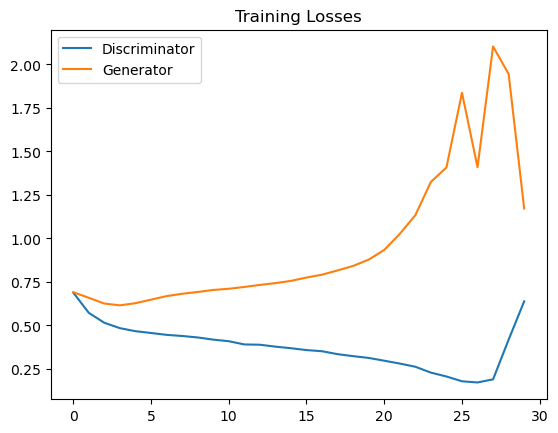

In [26]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [27]:
nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

In [28]:
results

array([1.        , 1.        , 0.99999988, ..., 1.        , 1.        ,
       1.        ])

In [29]:
y2 = y_test.to_numpy()

In [30]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Normal data :', results_df.loc[results_df['y_test'] == 1, 'results'].mean() )
print ('Mean score for Fall data :', results_df.loc[results_df['y_test'] == 0, 'results'].mean())

Mean score for Normal data : 0.999999970793724
Mean score for Fall data : 0.9756252184380656


In [31]:
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [32]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5008888888888889
Precision : 0.0
Recall : 0.0
F1 : 0.0


Confusion Matrix :


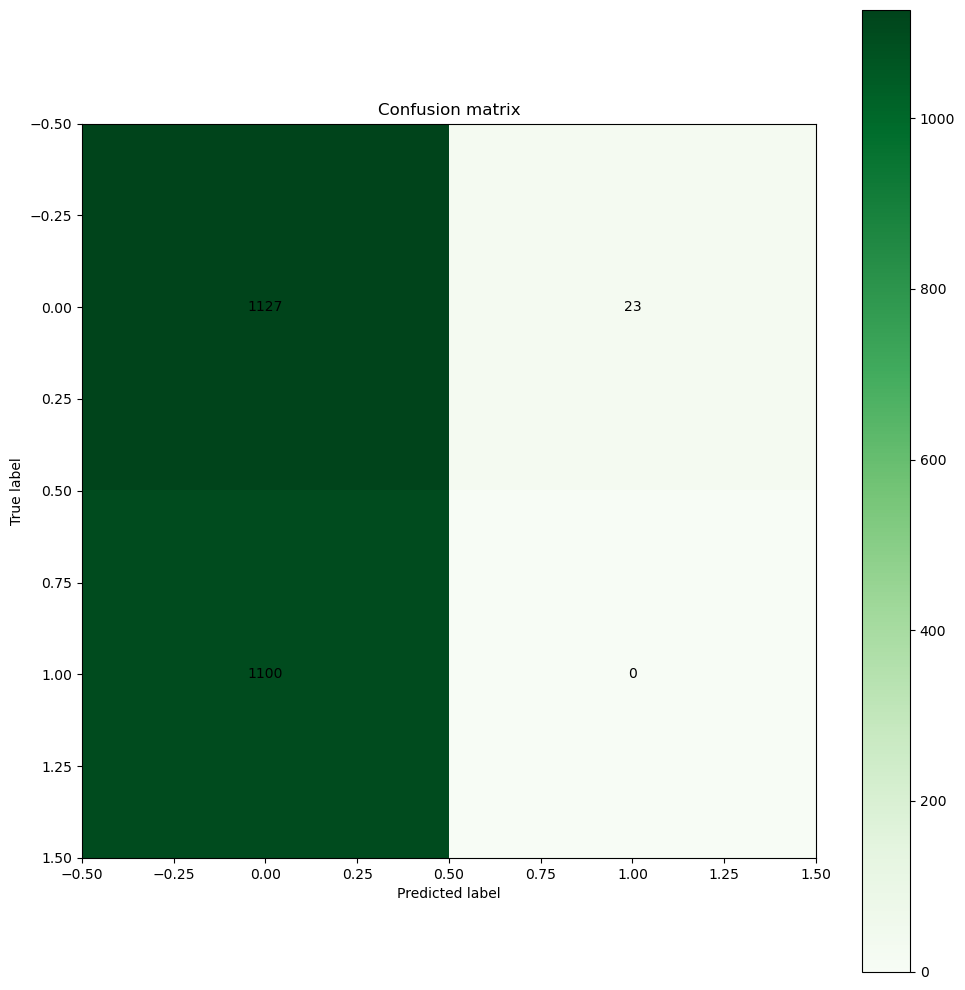

In [33]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

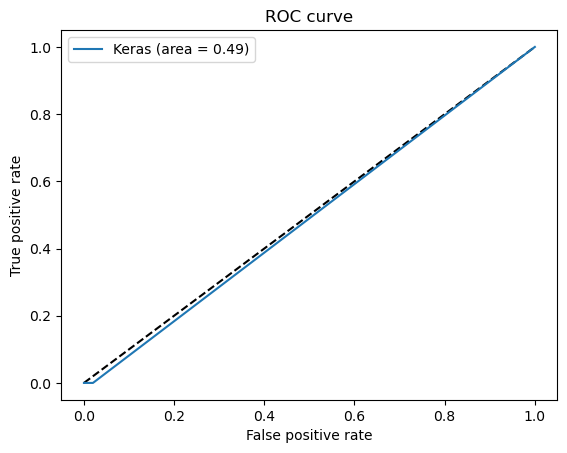

100%|██████████| 30/30 [00:20<00:00, 12.37it/s]

In [34]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()